# Importing Libraries

In [42]:
import numpy as np
import cv2
import os
from tqdm import tqdm
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

# Data Preprocessing

In [43]:
def data_preprocessing(image_ids, annotations, image_dir, input_size=(224, 224)):
    
    images = []
    bboxes = []
    
    for img_id in tqdm(image_ids, desc="Processing Data"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        img_path = os.path.join(image_dir, img_filename)
        
        # Load the image
        img = cv2.imread(img_path)
        
        # Check if image is loaded successfully
        if img is None:
            print(f"Could not load image: {img_path}")
            continue
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, input_size)
        
        # Normalize image to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        # Extract bounding boxes for the image
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]
        
        # If no annotations, skip this image
        if not img_annotations:
            continue
        
        # Get bounding boxes (x, y, width, height)
        boxes = []
        for ann in img_annotations:
            # Normalize bbox coordinates to [0, 1]
            bbox = ann['bbox']
            x, y, w, h = bbox
            x_norm = x / img_info['width']
            y_norm = y / img_info['height']
            w_norm = w / img_info['width']
            h_norm = h / img_info['height']
            boxes.append([x_norm, y_norm, w_norm, h_norm])
        
        # Use the first bounding box if multiple exist
        if boxes:
            images.append(img)
            bboxes.append(boxes[0])
    
    # Convert to numpy arrays
    images = np.array(images)
    bboxes = np.array(bboxes)
    
    return images, bboxes

# Loading & preprocessing the Data.

In [44]:
#Loading the data:

# Setting up the path for the data 
image_dir = "/Users/harshavardhan/data/coco_subset"
annotation_file = "/Users/harshavardhan/coco_annotations/annotations/instances_train2017.json"

# Loading the COCO annotations and images for first 10,000 images
coco = COCO(annotation_file)
image_ids = coco.getImgIds()[:10000]
annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_ids))

loading annotations into memory...
Done (t=6.98s)
creating index...
index created!


In [45]:
#Preprocessing the data:
images, bboxes = data_preprocessing(image_ids, annotations, image_dir)

Processing Data: 100%|███████████████████| 10000/10000 [01:38<00:00, 101.05it/s]


# Building the CNN model for bounding box

In [46]:
def building_cnn_for_bounding_box(input_shape=(224, 224, 3)):
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='linear')  # 4 outputs for [x, y, width, height]
    ])
    
    return cnn_model


# Fitting & Compiling the model

In [47]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [48]:
cnn_model = building_cnn_for_bounding_box()
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

/Users/harshavardhan/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training the model with the Data.

In [49]:
training_model = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 113s 450ms/step - loss: 0.2062 - mean_absolute_error: 0.2825 - val_loss: 0.0672 - val_mean_absolute_error: 0.2139
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 109s 441ms/step - loss: 0.0724 - mean_absolute_error: 0.2202 - val_loss: 0.0646 - val_mean_absolute_error: 0.2124
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 108s 437ms/step - loss: 0.0695 - mean_absolute_error: 0.2159 - val_loss: 0.0653 - val_mean_absolute_error: 0.2098
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 112s 452ms/step - loss: 0.0663 - mean_absolute_error: 0.2107 - val_loss: 0.0636 - val_mean_absolute_error: 0.2103
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 112s 452ms/step - loss: 0.0666 - mean_absolute_error: 0.2124 - val_loss: 0.0634 - val_mean_absolute_error: 0.2074
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 107s 433ms/step - loss: 0.0629 - mean_absolute_error: 0.2054 - val_loss: 0.0613 - val_mean_absolute_error: 0.2073
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 108s 436ms/step - loss: 0.0620 - mea

# Plotting the results of training the Images

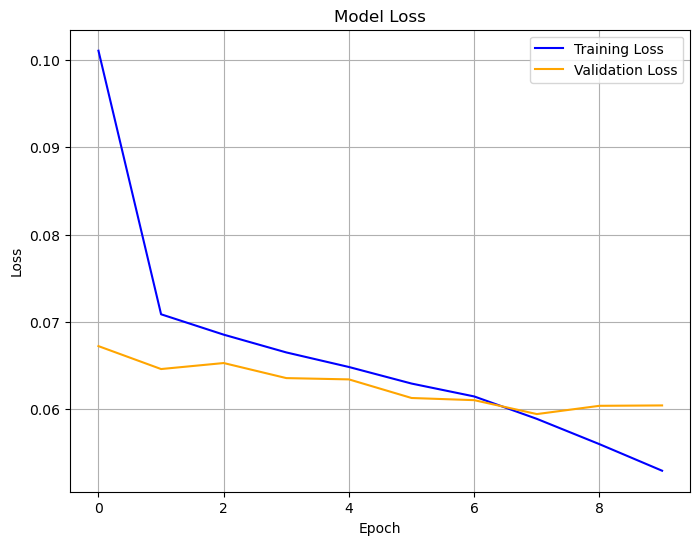

In [50]:
#Plotting for training loss.

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(training_model.history['loss'], label='Training Loss', color='blue')
plt.plot(training_model.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

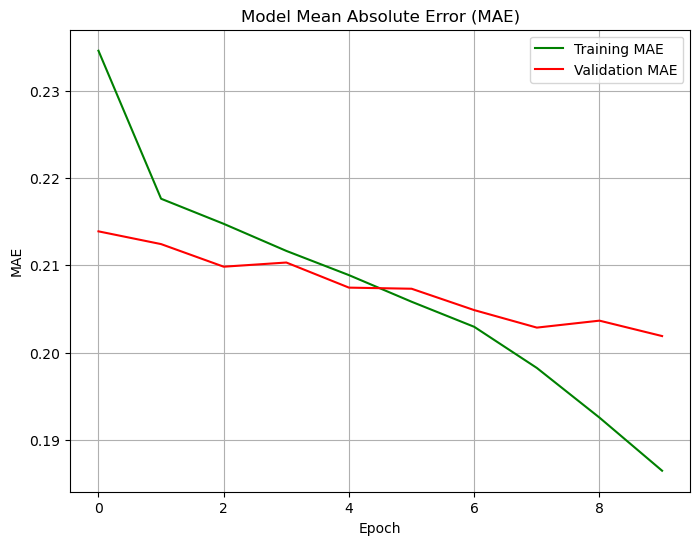

In [52]:
#Plotting for training MAE:

plt.figure(figsize=(8, 6))
plt.plot(training_model.history['mean_absolute_error'], label='Training MAE', color='green')
plt.plot(training_model.history['val_mean_absolute_error'], label='Validation MAE', color='red')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,704,270 (151.46 MB)

 Trainable params: 13,234,756 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,469,514 (100.97 MB)

# Saving the Model

In [54]:
# Saving the trained model
cnn_model.save('cnn_bounding_box_model.h5', save_format='h5')

# Loading the Model

In [55]:
loaded_model = load_model('cnn_bounding_box_model.h5')

# Checking if the results of the loaded model has the results same as training model

In [58]:
#Evaluating the model.
train_loss = loaded_model.evaluate(X_train, y_train)

248/248 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - loss: 0.0446 - mean_absolute_error: 0.1715
